In [1]:
! pip install torch scikit-learn imblearn matplotlib seaborn numpy pennylane umap-learn joblib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pennylane as qml
import umap
import joblib
import pandas as pd
import os
from imblearn.under_sampling import TomekLinks
from collections import Counter

Could not save font_manager cache [Errno 13] Permission denied: 'C:\\Users\\91720\\.matplotlib\\fontlist-v390.json.matplotlib-lock'
d:\QCNN\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ---------------------- LOAD LABELS ----------------------
labels_df = pd.read_csv("experiment-ii_labels.csv")
base_dir = "experiment-ii"
file_paths, unique_labels = [], []
for _, row in labels_df.iterrows():
    full_path = os.path.join(base_dir, row["Subject"], row["Mat_Type"], row["File_Name"])
    if os.path.exists(full_path):
        file_paths.append(full_path)
        unique_labels.append(row["Label"])
label_mapping = {label: idx for idx, label in enumerate(sorted(set(unique_labels)))}
labels = [label_mapping[lbl] for lbl in unique_labels]
# ---------------------- LOAD MATRIX FILES FROM .TXT ----------------------
X = []
for path in file_paths:
    try:
        matrix = np.loadtxt(path)  # Assumes whitespace- or tab-delimited .txt files
        X.append(matrix.flatten())  # Flatten 2D matrix to 1D
    except Exception as e:
        print(f"Failed to load {path}: {e}")
X = np.array(X)
Y = np.array(labels)

In [4]:
# 1. Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Autoencoder
class AutoEncoder(nn.Module):
    def __init__(self, input_size, encoded_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128), nn.ReLU(),
            nn.Linear(128, encoded_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoded_size, 128), nn.ReLU(),
            nn.Linear(128, input_size), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

input_size = X_scaled.shape[1]
encoded_size = 50

autoencoder = AutoEncoder(input_size, encoded_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [6]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
for epoch in range(150):
    optimizer.zero_grad()
    reconstructed = autoencoder(X_tensor)
    loss = criterion(reconstructed, X_tensor)
    loss.backward()
    optimizer.step()

X_encoded = autoencoder.encode(X_tensor).detach().numpy()

In [8]:
# 3. UMAP for further dimensionality reduction (to match qubit count)
n_qubits = 11
umap_model = umap.UMAP(n_components=n_qubits, random_state=42)
X_umap = umap_model.fit_transform(X_encoded)

joblib.dump(umap_model, "umap7_model.pkl")

d:\QCNN\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\QCNN\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


['umap7_model.pkl']

In [10]:
# 1. Handle class imbalance using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_umap, Y)

# 3. Print class distribution after applying SMOTE + Tomek Links
label_counts = Counter(y_balanced)
print("Class distribution after SMOTE:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")

Class distribution after SMOTE:
Label 2: 271 samples
Label 1: 271 samples
Label 0: 271 samples


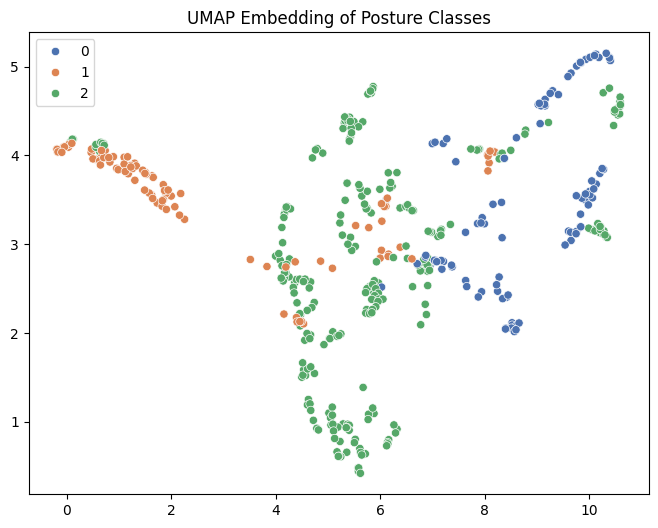

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=Y, palette="deep")
plt.title("UMAP Embedding of Posture Classes")
plt.show()


In [13]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np

# ---------- CONFIGURATION ----------
num_qubits = 11
qml_dev = qml.device("default.qubit", wires=num_qubits)

# ---------- QUANTUM CONVOLUTION LAYER ----------
def QuantumConvLayer(x, weights):
    batch_size = x.shape[0]

    @qml.qnode(qml_dev, interface="torch")
    def circuit(x_, w):
        qml.AngleEmbedding(x_, wires=range(num_qubits), rotation="Y")
        for l in range(w.shape[0]):
            for i in range(num_qubits):
                qml.RY(w[l, i, 0], wires=i)
                qml.RZ(w[l, i, 1], wires=i)
            for i in range(num_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            qml.CNOT(wires=[num_qubits - 1, 0])
        return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

    result = [torch.tensor(circuit(x[i], weights)) for i in range(batch_size)]
    return torch.stack(result).to(torch.float32)

# ---------- QUANTUM POOLING LAYER ----------
def QuantumPoolingLayer(x):
    batch_size = x.shape[0]

    @qml.qnode(qml_dev, interface="torch")
    def circuit(x_):
        qml.AngleEmbedding(x_, wires=range(num_qubits), rotation="Y")
        for i in range(0, num_qubits - 1, 2):
            qml.CRY(np.pi / 2, wires=[i, i + 1])
        return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

    result = [torch.tensor(circuit(x[i])) for i in range(batch_size)]
    return torch.stack(result).to(torch.float32)

# ---------- HYBRID QUANTUM-CLASSICAL QCNN ----------
class QCNN(nn.Module):
    def __init__(self, num_qubits=11, num_layers=6, num_classes=3):
        super(QCNN, self).__init__()
        self.num_qubits = num_qubits
        self.num_layers = num_layers

        # Quantum layer parameters (deeper entanglement)
        self.q_params = nn.ParameterList([
            nn.Parameter(0.01 * torch.randn(num_layers, num_qubits, 2))
            for _ in range(num_layers)
        ])

        # Classical fully connected layers with GELU activation and batch norm
        self.fc1 = nn.Linear(num_qubits, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(p=0.3)
        self.act = nn.GELU()

    def forward(self, x, return_quantum_features=False):
        if isinstance(x, list):
            x = torch.stack(x)
        if isinstance(x, torch.Tensor):
            x = x.to(torch.float32)
        if len(x.shape) == 1:
            x = x.unsqueeze(0)

        # Quantum convolution and pooling layers
        for i in range(self.num_layers):
            x = QuantumConvLayer(x, self.q_params[i])
            x = QuantumPoolingLayer(x)

        # Flatten the output for classical layers
        x = x.view(x.shape[0], -1)

        # Fully connected layers
        x = self.act(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.act(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


In [15]:
# 1. Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# 2. Convert the data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 3. Create TensorDatasets for the train and test data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 4. Create DataLoaders for batching
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [20]:
# Check label shape before loss
print("Labels shape:", labels.shape)      # Should be [batch_size]
print("Labels dtype:", labels.dtype)      # Should be torch.long
print("Outputs shape:", outputs.shape)    # Should be [batch_size, num_classes]

# Ensure labels are in the correct shape
if labels.ndim > 1:
    labels = torch.argmax(labels, dim=1)  # Convert one-hot to class indices




Labels shape: torch.Size([32])
Labels dtype: torch.int64
Outputs shape: torch.Size([32, 3])


In [23]:
from sklearn.utils.class_weight import compute_class_weight

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
model = QCNN(num_qubits=num_qubits).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_balanced), y=y_balanced)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion=torch.nn.CrossEntropyLoss()

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)  # step every 10 epochs, reduce LR by 30%


In [24]:
# Metrics storage
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Ensure input is flat and of correct dimension [batch_size, 11]
        inputs = inputs.view(inputs.size(0), -1)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_train_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            running_val_loss += val_loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = running_val_loss / len(test_loader)
    val_accuracy = correct_val / total_val

    # Store metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{n_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")


Epoch 1/20
Train Loss: 1.1066, Train Accuracy: 31.69%
Val Loss: 1.0960, Val Accuracy: 31.29%
Epoch 2/20
Train Loss: 1.1048, Train Accuracy: 31.23%
Val Loss: 1.1058, Val Accuracy: 31.29%
Epoch 3/20
Train Loss: 1.1031, Train Accuracy: 34.00%
Val Loss: 1.1738, Val Accuracy: 31.29%
Epoch 4/20
Train Loss: 1.0991, Train Accuracy: 34.46%
Val Loss: 1.1689, Val Accuracy: 31.29%
Epoch 5/20
Train Loss: 1.1024, Train Accuracy: 34.62%
Val Loss: 1.3923, Val Accuracy: 34.36%
Epoch 6/20
Train Loss: 1.1042, Train Accuracy: 34.15%
Val Loss: 1.5669, Val Accuracy: 31.29%
Epoch 7/20
Train Loss: 1.1022, Train Accuracy: 32.77%
Val Loss: 1.4695, Val Accuracy: 31.29%
Epoch 8/20
Train Loss: 1.0994, Train Accuracy: 35.38%
Val Loss: 1.2948, Val Accuracy: 31.29%
Epoch 9/20
Train Loss: 1.1014, Train Accuracy: 35.69%
Val Loss: 1.1415, Val Accuracy: 34.36%
Epoch 10/20
Train Loss: 1.1030, Train Accuracy: 33.54%
Val Loss: 1.1077, Val Accuracy: 31.29%
Epoch 11/20
Train Loss: 1.1038, Train Accuracy: 34.46%
Val Loss: 1.11

In [25]:
# ---------- FINAL TESTING ----------
model.eval()  # Set model to evaluation mode
test_loss = 0.0
correct_test = 0
total_test = 0

# Store the final test metrics
test_losses = []
test_accuracies = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)  # Accumulate loss

        # Get predicted class labels
        predicted = torch.argmax(outputs, dim=1)

        # Count correct predictions
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

# Calculate average test loss and accuracy
avg_test_loss = test_loss / total_test
test_accuracy = correct_test / total_test

# Store final test metrics
test_losses.append(avg_test_loss)
test_accuracies.append(test_accuracy)

# Print final test results
print("---------- FINAL TEST RESULTS ----------")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


---------- FINAL TEST RESULTS ----------
Test Loss: 1.0992
Test Accuracy: 31.29%


In [26]:
# Assume `model` is your trained QCNN instance
torch.save(model.state_dict(), "qcnn7_model.pth")
print("✅ Trained QCNN model  saved as 'qcnn7_model.pth'")

✅ Trained QCNN model  saved as 'qcnn7_model.pth'


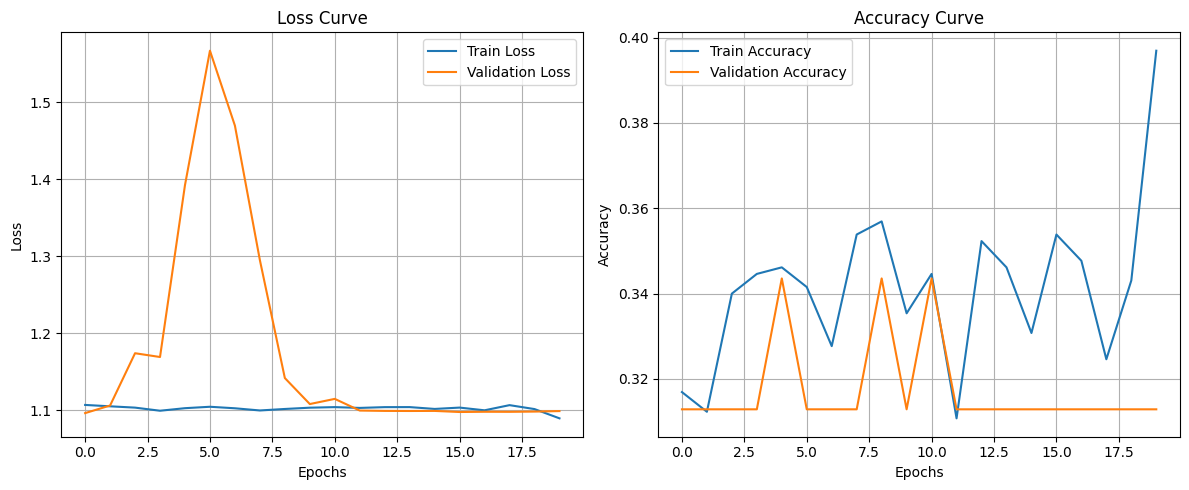

In [28]:
# -------- Loss & Accuracy Curves --------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

---------- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

           0       0.31      1.00      0.48        51
           1       0.00      0.00      0.00        56
           2       0.00      0.00      0.00        56

    accuracy                           0.31       163
   macro avg       0.10      0.33      0.16       163
weighted avg       0.10      0.31      0.15       163



d:\QCNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\QCNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\QCNN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


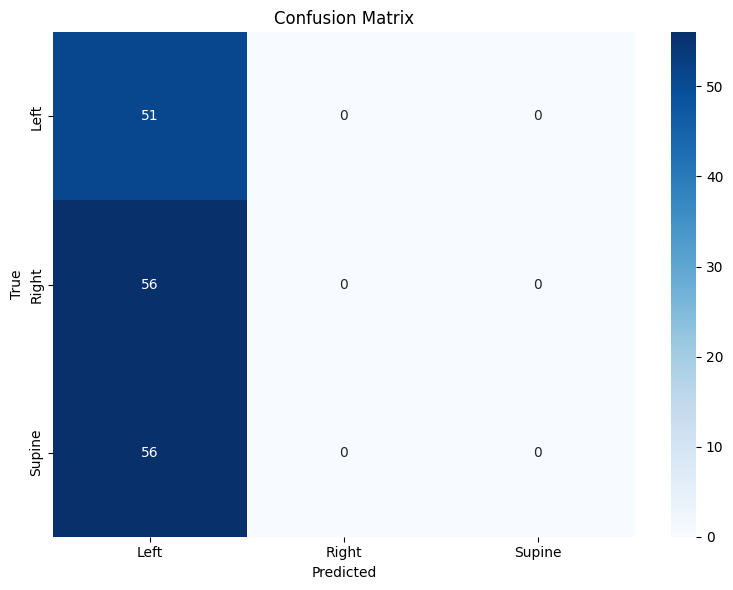

In [29]:
# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("---------- CLASSIFICATION REPORT ----------")
print(classification_report(all_labels, all_preds))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


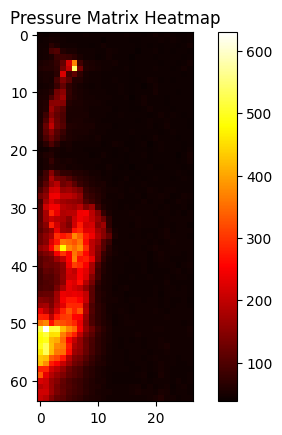

d:\QCNN\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


RuntimeError: Error(s) in loading state_dict for QCNN:
	Unexpected key(s) in state_dict: "q_params.4", "q_params.5". 
	size mismatch for q_params.0: copying a param with shape torch.Size([6, 11, 2]) from checkpoint, the shape in current model is torch.Size([4, 11, 2]).
	size mismatch for q_params.1: copying a param with shape torch.Size([6, 11, 2]) from checkpoint, the shape in current model is torch.Size([4, 11, 2]).
	size mismatch for q_params.2: copying a param with shape torch.Size([6, 11, 2]) from checkpoint, the shape in current model is torch.Size([4, 11, 2]).
	size mismatch for q_params.3: copying a param with shape torch.Size([6, 11, 2]) from checkpoint, the shape in current model is torch.Size([4, 11, 2]).

In [30]:
# Prediction function
def predict_from_file(file_path):
    if not os.path.exists(file_path):
        print("File does not exist.")
        return

    # Load and visualize pressure matrix
    matrix = np.loadtxt(file_path)
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.title("Pressure Matrix Heatmap")
    plt.colorbar()
    plt.show()

    # Preprocess: scale, flatten, reduce
    matrix_flat = matrix.flatten().reshape(1, -1)

    # Now check shape match
    if matrix_flat.shape[1] != scaler.n_features_in_:
        raise ValueError(f"Expected {scaler.n_features_in_} features, but got {matrix_flat.shape[1]}")

    matrix_scaled = scaler.transform(matrix_flat)

    # Load trained UMAP model
    umap_model = joblib.load("umap5_model.pkl")
    matrix_umap = umap_model.transform(matrix_scaled)
    input_tensor = torch.tensor(matrix_umap, dtype=torch.float32)

    # Load model
    model = QCNN(11,4, num_classes=3)  # Update num_classes if needed
    model.load_state_dict(torch.load("qcnn7_model.pth", map_location=torch.device('cpu')))
    model.eval()

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    # Define label mapping manually or load from file if saved
    label_mapping = {label: idx for idx, label in enumerate(sorted(labels_df['Label'].unique()))}
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}

    print(f"Predicted Posture: {reverse_label_mapping.get(pred, 'Unknown')}")

predict_from_file("D:/QCNN/experiment-ii/S1/Sponge_Mat/Matrix_Sponge_C1.txt")